In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import xtrack as xt

## Import MAD-X sequence to Xsuite

In [3]:
import numpy as np
from cpymad.madx import Madx
import xtrack as xt

mad = Madx()
mad.input("beam, particle=proton, pc = 14.0;")
mad.input("brho = beam->pc * 3.3356;")
mad.call("../../xtrack/test_data/ps_sftpro/ps.seq")
mad.call("../../xtrack/test_data/ps_sftpro/ps_hs_sftpro.str")
mad.use('ps')

line = xt.Line.from_madx_sequence(mad.sequence.ps, allow_thick=True,
                                  deferred_expressions=True,
                                  )
line.particle_ref = xt.Particles(mass0=xt.PROTON_MASS_EV,
                                    q0=1, gamma0=mad.sequence.ps.beam.gamma)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.12.04               +
  + Execution date: 2024.02.21 19:24:45      +
  ++++++++++++++++++++++++++++++++++++++++++++




  /**********************************************************************************

  *

  * PS Ring version (draft) YETS 2022-2023 in MAD X SEQUENCE format

  * Generated the 20-MAR-2023 19:11:31 from Layout

  *

  ***********************************************************************************/





/************************************************************************************/

/*                       TYPES DEFINITION                                           */

/************************************************************************************/



//---------------------- HKICKER        ---------------------------------------------

PR_BFA__001    : HKICKER     , L := .54;       ! B

Converting sequence "ps":   0%|          | 0/1717 [00:00<?, ?it/s]

### Match tune

In [4]:
opt = line.match(
    method='4d',
    solve=False,
    vary=[xt.VaryList(['kf', 'kd'], step=1e-5)],
    targets=[xt.TargetSet(qx=6.255278, qy=6.29826, tol=1e-7)],
)
opt.solve()

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Matching: model call n. 4               



### Inspect phase space

Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'px')

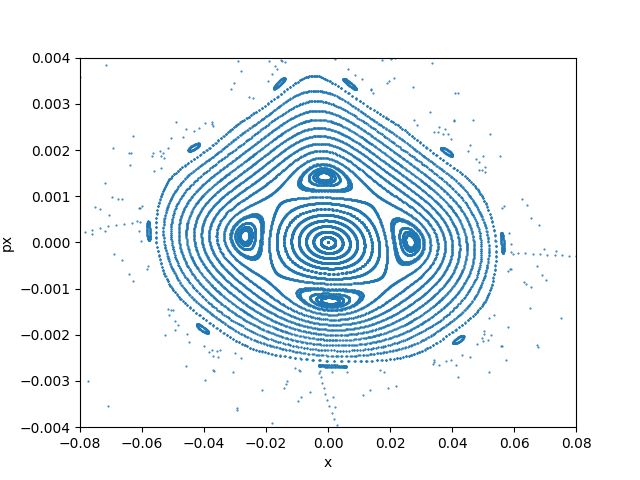

In [5]:
# Generate some particles close on the x axis in normalized phase sepace
r0 = np.linspace(0, 100, 50)
p = line.build_particles(
    method='4d', 
    x_norm=r0*np.cos(np.pi/20.),
    px_norm=0,
    nemitt_x=1e-6, nemitt_y=1e-6)

line.track(p, num_turns=1000, turn_by_turn_monitor=True, with_progress=True)
mon = line.record_last_track

import matplotlib.pyplot as plt
plt.close('all')
plt.figure(1)
plt.plot(mon.x.flatten(), mon.px.flatten(), '.', markersize=1)
plt.ylim(-0.004, 0.004)
plt.xlim(-0.08, 0.08)
plt.xlabel('x')
plt.ylabel('px')

### Standard twiss

In [6]:
tw_core = line.twiss(num_turns=0, method='4d')
tw_core.qx, tw_core.qy

(6.2552780029975175, 6.298260002240552)

### Multi-turn twiss

In [7]:
tw_mt = line.twiss(co_guess={'x': 0.025}, num_turns=4, method='4d')
tw_mt.mux[-1], tw_mt.muy[-1]

(24.97494199038094, 25.210814312947495)

### Select rows corresponding to start turns

In [8]:
tw_start_turns = tw_mt.rows['_turn_.*']
tw_start_turns.show()

name                        s           x          px            y           py         zeta delta ...
_turn_0                     0   0.0265291 2.47905e-05  4.91659e-26  7.37855e-27 -6.80991e-30     0
_turn_1               628.319 0.000582581 -0.00126273  7.36717e-26  -7.0415e-27  -0.00370755     0
_turn_2               1256.64  -0.0269299 0.000141528 -9.04475e-26 -3.72995e-27  0.000679612     0
_turn_3               1884.96 -0.00130686   0.0014305  -2.1741e-26  8.01415e-27   0.00459079     0


### Plot twiss results on top of tracking data

Text(0, 0.5, 'px')

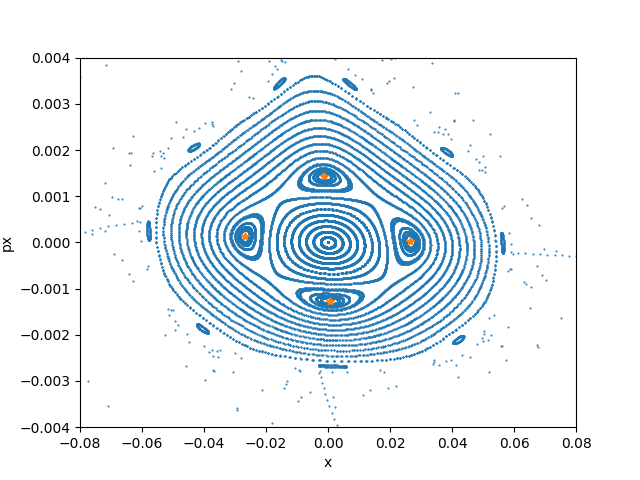

In [9]:
plt.figure()
plt.plot(mon.x.flatten(), mon.px.flatten(), '.', markersize=1)
plt.plot(tw_start_turns.x, tw_start_turns.px, '*')
plt.ylim(-0.004, 0.004)
plt.xlim(-0.08, 0.08)
plt.xlabel('x')
plt.ylabel('px')

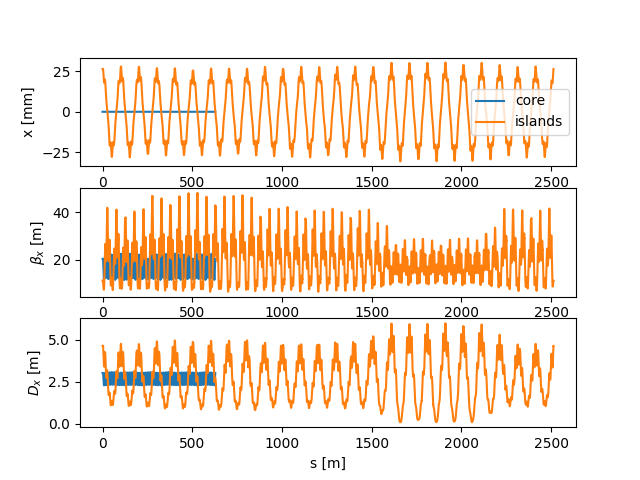

In [10]:
plt.figure()
ax1 = plt.subplot(3,1,1)
plt.plot(tw_core.s, tw_core.x * 1e3, label='core')
plt.plot(tw_mt.s, tw_mt.x * 1e3, label='islands')
plt.legend()
plt.ylabel('x [mm]')
plt.subplot(3,1,2, sharex=ax1)
plt.plot(tw_core.s, tw_core.betx)
plt.plot(tw_mt.s, tw_mt.betx)
plt.ylabel(r'$\beta_x$ [m]')
plt.subplot(3,1,3, sharex=ax1)
plt.plot(tw_core.s, tw_core.dx)
plt.plot(tw_mt.s, tw_mt.dx)
plt.xlabel('s [m]')
plt.ylabel(r'$D_x$ [m]')
plt.subplots_adjust(left=.15)

plt.show()